## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns

#sklearn modules
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
data = pd.read_csv("Commercial_Property.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       2450 non-null   int64 
 1   name             2450 non-null   object
 2   sqft             2450 non-null   int64 
 3   sqm              2450 non-null   object
 4   psf              2450 non-null   int64 
 5   location         2449 non-null   object
 6   amenities        2450 non-null   object
 7   amenities_count  2450 non-null   int64 
 8   price            2450 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 172.4+ KB


In [4]:
data.isnull().sum()

Unnamed: 0         0
name               0
sqft               0
sqm                0
psf                0
location           1
amenities          0
amenities_count    0
price              0
dtype: int64

We can see that there is 1 null value in the column location.

In [5]:
data.describe()

,Unnamed: 0,sqft,psf,amenities_count,price
count,2450.000000,2450.000000,2450.000000,2450.000000,2.450000e+03
mean,1224.500000,4336.850612,2417.108571,2.081224,4.842904e+06
std,707.398403,14872.132029,13316.339298,2.475757,2.328868e+07
min,0.000000,4.000000,0.000000,0.000000,6.500000e+02
25%,612.250000,635.000000,478.250000,0.000000,9.000000e+05
50%,1224.500000,1504.500000,1619.500000,1.000000,1.650000e+06
75%,1836.750000,2932.750000,3045.750000,4.000000,3.300000e+06
max,2449.000000,327433.000000,649000.000000,8.000000,4.500000e+08


In [6]:
data.head()

,Unnamed: 0,name,sqft,sqm,psf,location,amenities,amenities_count,price
0,0,Factory in Shine@Tuas South,3391,315.03,478,Tuas (D22),[],0,1620735
1,1,Factory in Lam Soon Industrial Building,1658,154.03,802,Choa Chu Kang (D23),[],0,1330000
2,2,Office in Plus,3477,323.02,3088,Marina (D1),"['Air conditioning', 'Security access']",2,10736419
3,3,Office in Plus,1647,153.01,3258,Marina (D1),"['Air conditioning', 'Security access']",2,5365883
4,4,Office in Plus,2304,214.05,3272,Marina (D1),"['Air conditioning', 'Security access']",2,7537855


## Preprocessing

In [7]:
data = data.drop(['Unnamed: 0'], axis=1)
data["sqm"] = data["sqm"].str.replace(",","")
data["sqm"] = data["sqm"].astype("float")
data = data.dropna()
#data["amenities"] = data["amenities"].apply(lambda x: x.replace("'","").replace("[","").replace("]","").strip().split(","))
data["amenities"] = data["amenities"].apply(eval)
data.drop(data[data.psf > 20000].index, inplace=True)
data.drop(data[data.sqm > 20000].index, inplace=True)
data.drop(data[data.price > 150000000].index, inplace=True)

<AxesSubplot:>

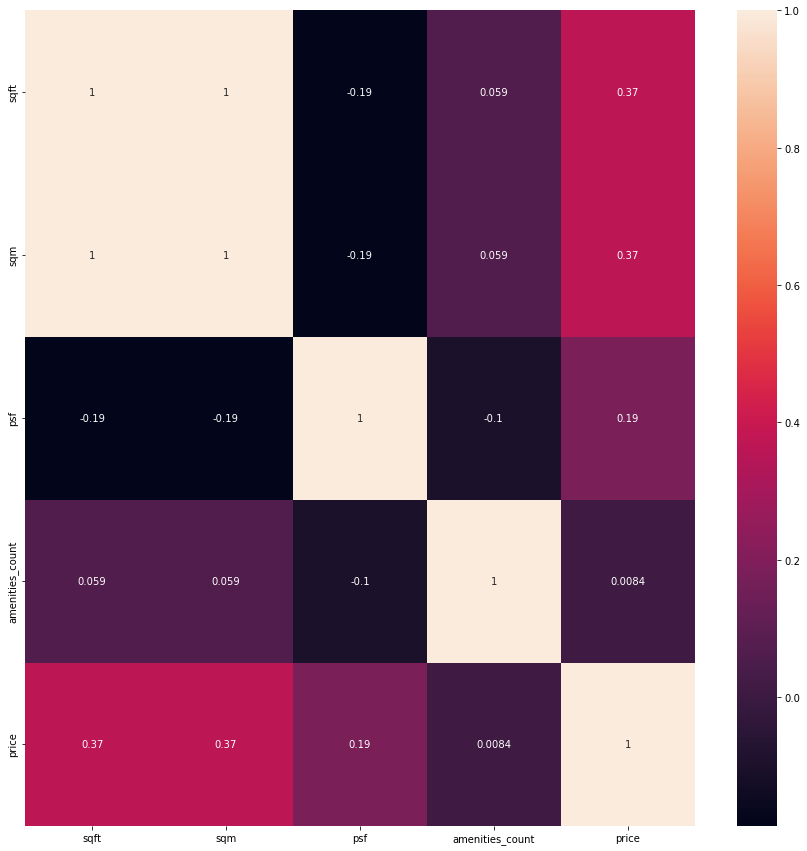

In [8]:
corr_matrix = data.corr()
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True)

From our correlation matrix, we can see that sqft and sqm have the highest correlation of 0.37, followed by psf of 0.19.

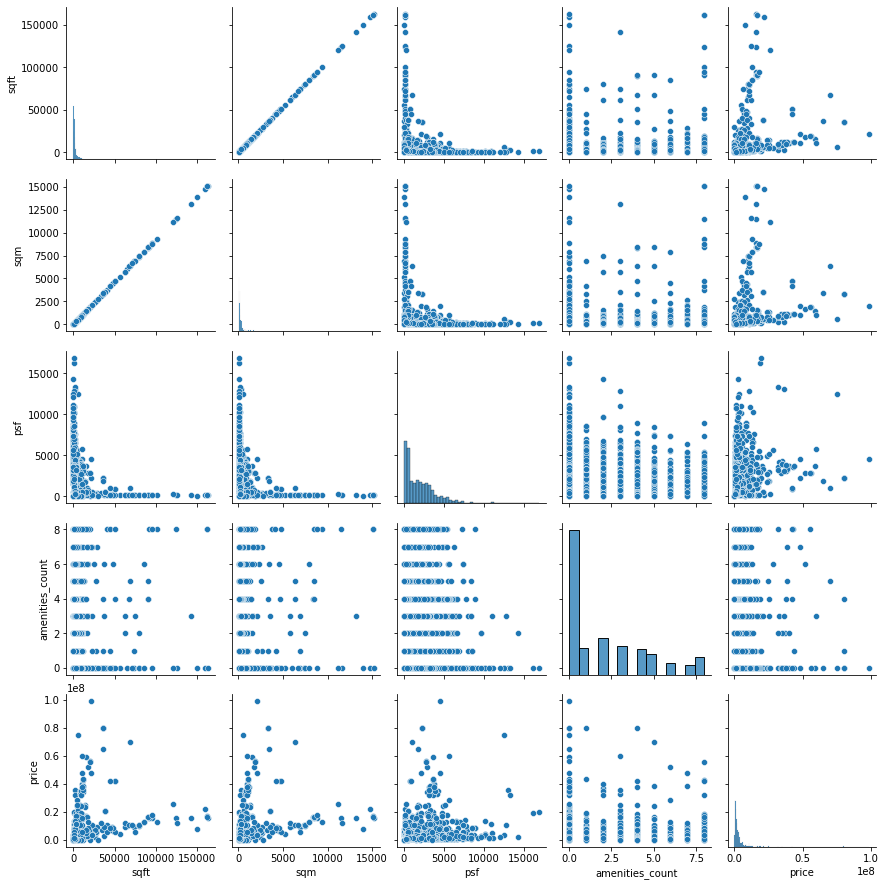

In [9]:
sns.pairplot(data, height=2.5)

### One-hot Encode Amenities list

In [10]:
columns = [c for c in data.columns]
s = data.amenities.explode()
data = data[columns].join(pd.crosstab(s.index, s))
data = data.fillna(0)
data.head()

,name,sqft,sqm,psf,location,amenities,amenities_count,price,24 hr access,450 lux lighting,...,Pantry,Raised floor,Reception services,Secretarial services,Security access,Server room,Svc/smatv system,Turnstile,Videoconferencing,Water trap
0,Factory in Shine@Tuas South,3391,315.03,478,Tuas (D22),[],0,1620735,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Factory in Lam Soon Industrial Building,1658,154.03,802,Choa Chu Kang (D23),[],0,1330000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Office in Plus,3477,323.02,3088,Marina (D1),"[Air conditioning, Security access]",2,10736419,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Office in Plus,1647,153.01,3258,Marina (D1),"[Air conditioning, Security access]",2,5365883,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Office in Plus,2304,214.05,3272,Marina (D1),"[Air conditioning, Security access]",2,7537855,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data = data.drop("amenities",axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2435 entries, 0 to 2449
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  2435 non-null   object 
 1   sqft                  2435 non-null   int64  
 2   sqm                   2435 non-null   float64
 3   psf                   2435 non-null   int64  
 4   location              2435 non-null   object 
 5   amenities_count       2435 non-null   int64  
 6   price                 2435 non-null   int64  
 7   24 hr access          2435 non-null   float64
 8   450 lux lighting      2435 non-null   float64
 9   Air conditioning      2435 non-null   float64
 10  Av equipment          2435 non-null   float64
 11  Backup generator      2435 non-null   float64
 12  Bath room             2435 non-null   float64
 13  Broadband             2435 non-null   float64
 14  Car park              2435 non-null   float64
 15  Cat 5/6 cabling      

We can see that most of our features are now of numeric values except for location.

### location against price

In [13]:
data.location.value_counts()

Paya Lebar (D14)           396
Tuas (D22)                 232
Marina (D1)                228
Commonwealth (D3)          150
Rochor (D7)                139
Yishun (D27)               137
Sengkang (D19)             129
Woodlands (D25)            125
Serangoon Rd (D8)           97
Toa Payoh (D12)             87
Thomson (D20)               87
Clementi (D5)               80
River Valley (D9)           68
Choa Chu Kang (D23)         63
Clarke Quay (D6)            60
Potong Pasir (D13)          56
Tanjong Pagar (D2)          56
Marine Parade (D15)         54
Upper Bukit Timah (D21)     43
Upper East Coast (D16)      38
Tampines (D18)              24
Holland (D10)               18
Changi Village (D17)        18
Telok Blangah (D4)          17
Upper Thomson (D26)         15
Novena (D11)                13
Yio Chu Kang (D28)           5
Name: location, dtype: int64

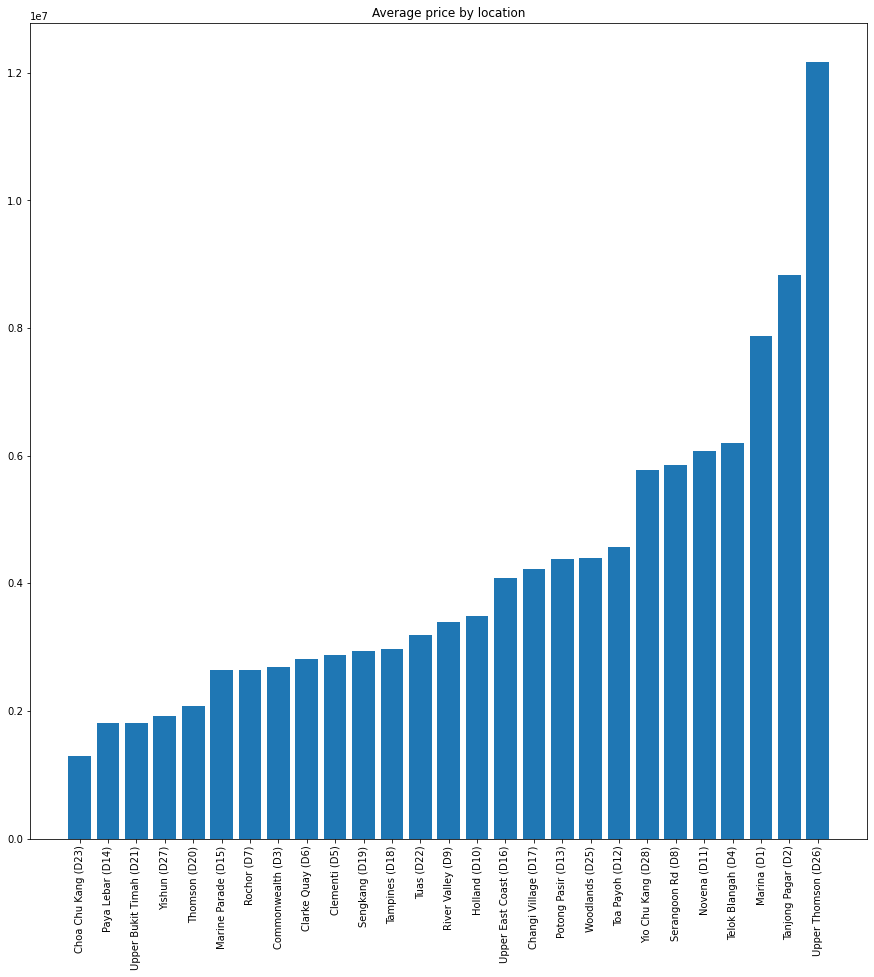

In [14]:
group_location = data.groupby(["location"])["price"].mean()

group_location_sorted = group_location.sort_values()

fig, ax = plt.subplots(figsize=(15, 15))
plt.bar(group_location_sorted.index, group_location_sorted.values)
plt.xticks(rotation=90)
plt.title("Average price by location")
#plt.ticklabel_format(style='plain')
#plt.ticklabel_format(useOffset=False)
plt.show()

In [15]:
encoder = OrdinalEncoder()
data["location"] = encoder.fit_transform(data["location"].values.reshape(-1,1))

### sqft against price

Pearson correlation pvalue = 4.3228025925887033e-79


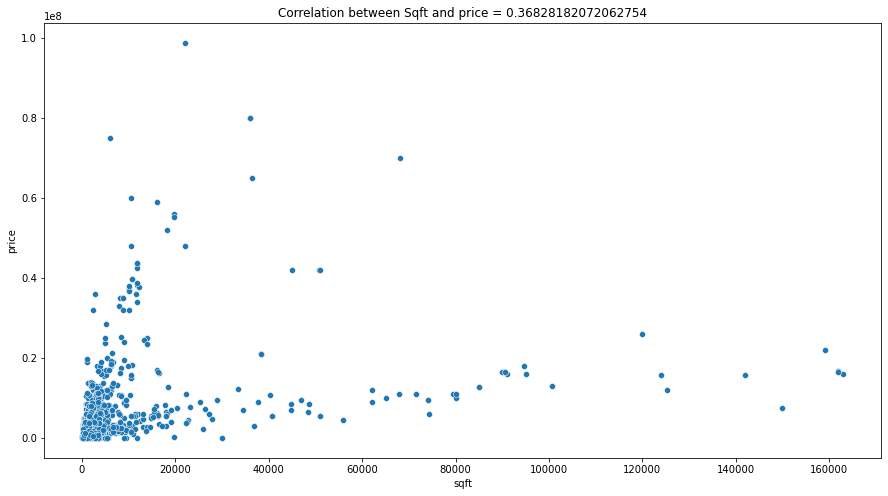

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=data, x='sqft', y='price', ax=ax)

r, pvalue = stats.pearsonr(data['sqft'], data['price'])
print(f'Pearson correlation pvalue = {pvalue}')

ax.set_title(f'Correlation between Sqft and price = {r}')
plt.show()

### sqm against price

Pearson correlation pvalue = 4.32251515729036e-79


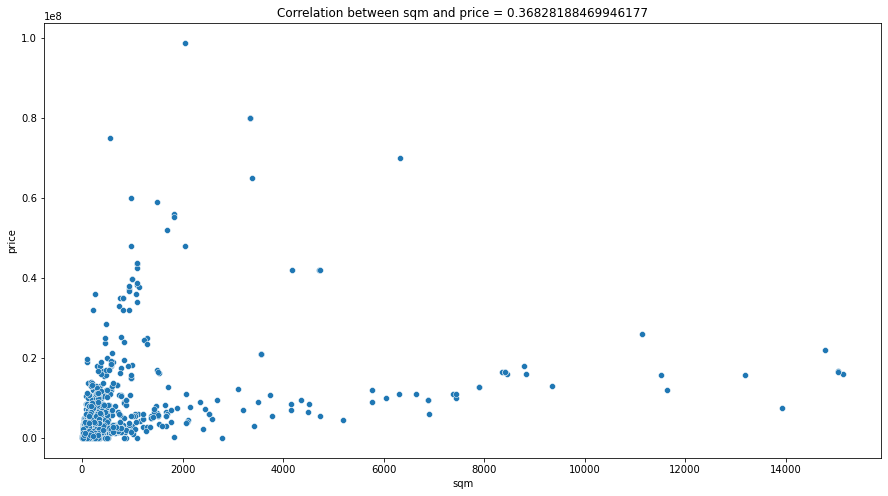

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=data, x='sqm', y='price', ax=ax)

r, pvalue = stats.pearsonr(data['sqm'], data['price'])
print(f'Pearson correlation pvalue = {pvalue}')

ax.set_title(f'Correlation between sqm and price = {r}')
plt.show()

### psf against price

Pearson correlation pvalue = 3.0552327660183926e-20


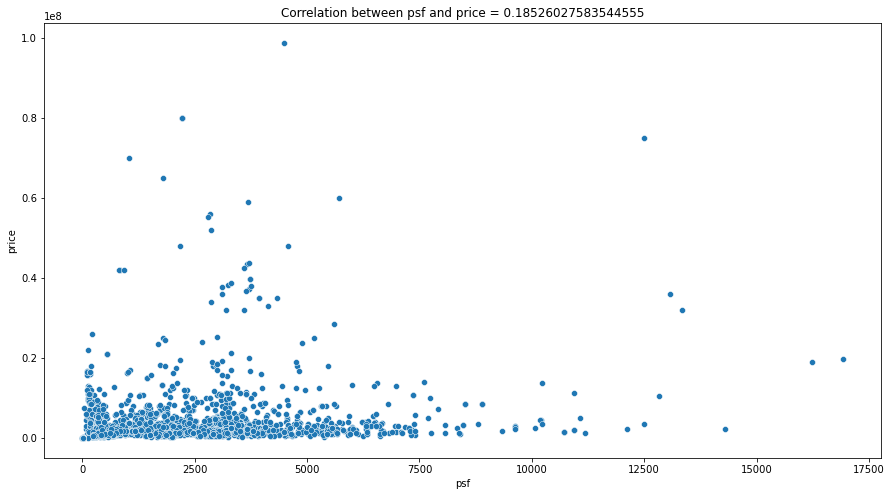

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=data, x='psf', y='price', ax=ax)

r, pvalue = stats.pearsonr(data['psf'], data['price'])
print(f'Pearson correlation pvalue = {pvalue}')

ax.set_title(f'Correlation between psf and price = {r}')
plt.show()

### amenities_count against price

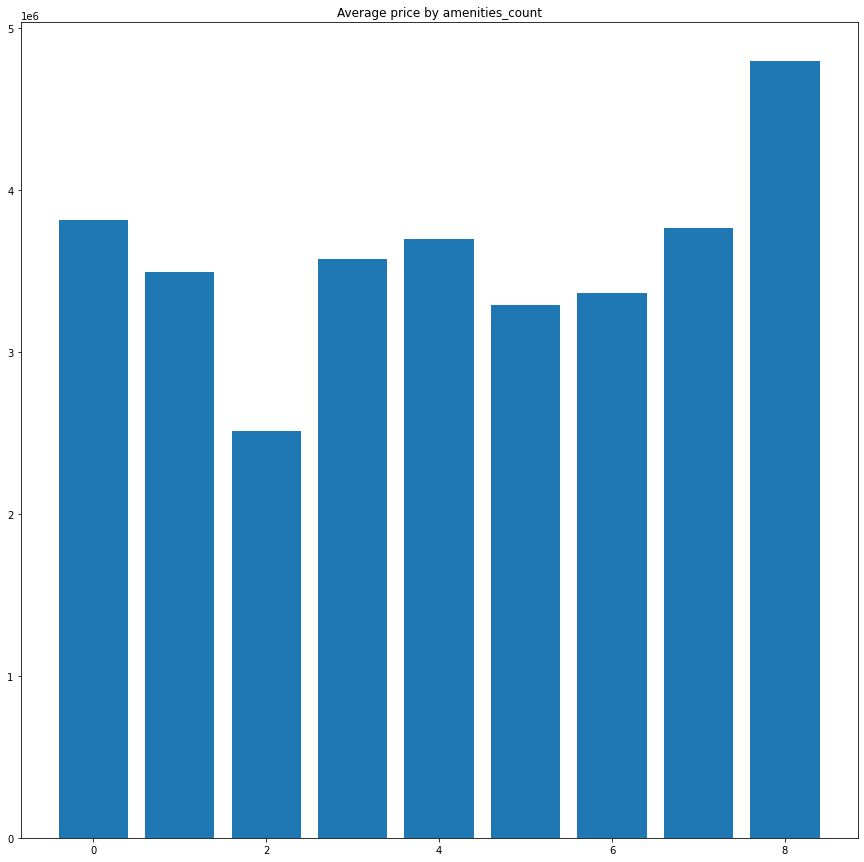

In [19]:
group_amenities = data.groupby(["amenities_count"])["price"].mean()

group_amenities_sorted = group_amenities.sort_values()

fig, ax = plt.subplots(figsize=(15, 15))
plt.bar(group_amenities_sorted.index, group_amenities_sorted.values)
#plt.xticks(rotation=90)
plt.title("Average price by amenities_count")
plt.show()

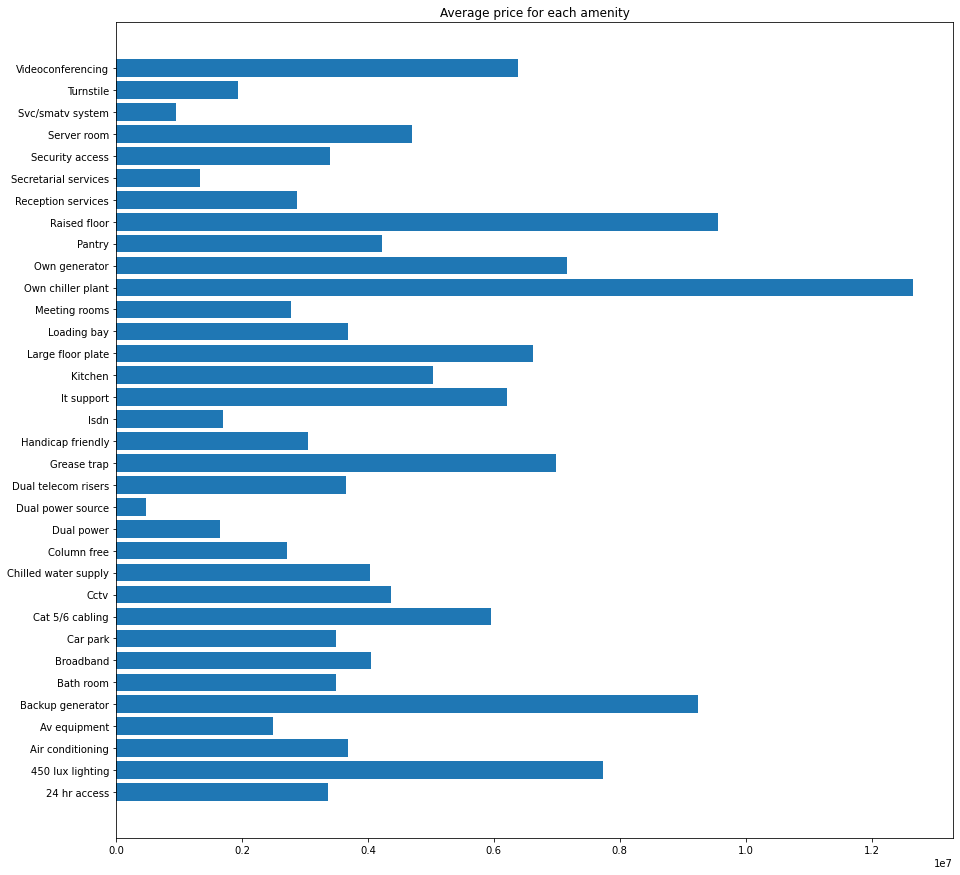

In [20]:
amenities_avg_price = []
columns = data.columns[7:-1]
for c in columns:
    amenities_avg_price.append(data.groupby([c])["price"].mean()[1.0])

fig, ax = plt.subplots(figsize=(15, 15))
plt.barh(columns, amenities_avg_price)
#plt.xticks(rotation=90)
plt.title("Average price for each amenity")
plt.show()

We can see that the top 3 amenities with the highest average price are "Own chiller plant", "Raised floor" and "Backup generator"

### Standard Scaler to normalize numerical features

In [21]:
scaler = StandardScaler()
data["sqft"] = scaler.fit_transform(data[["sqft"]])
data["sqm"] = scaler.fit_transform(data[["sqm"]])
data["psf"] = scaler.fit_transform(data[["psf"]])
data.head()

,name,sqft,sqm,psf,location,amenities_count,price,24 hr access,450 lux lighting,Air conditioning,...,Pantry,Raised floor,Reception services,Secretarial services,Security access,Server room,Svc/smatv system,Turnstile,Videoconferencing,Water trap
0,Factory in Shine@Tuas South,-0.050719,-0.050722,-0.786886,20.0,0,1620735,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Factory in Lam Soon Industrial Building,-0.190240,-0.190243,-0.626576,1.0,0,1330000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Office in Plus,-0.043795,-0.043798,0.504497,6.0,2,10736419,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Office in Plus,-0.191126,-0.191127,0.588610,6.0,2,5365883,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Office in Plus,-0.138232,-0.138231,0.595537,6.0,2,7537855,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Train Test Split

In [22]:
columns = data.columns
feature_list = []
for c in columns:
    if c =="name" or c=="price":
        continue
    feature_list.append(c)

In [23]:
features = data[feature_list]
target = data["price"]

In [24]:
X_train, X_test, y_train,  y_test = train_test_split(features, target, test_size=0.2)
print('Training set size = ', len(X_train))
print('Testing set size = ', len(X_test))

Training set size =  1948
Testing set size =  487


# Model Building (Regression)

## Model Building: Linear Regression

Linear Regression RMSE: 5517994.94091336
Linear Regression R2: 0.17984061190792644


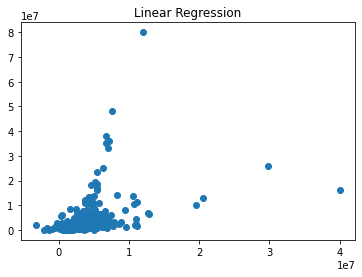

In [25]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_prediction = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, lr_prediction)
lr_rmse = np.sqrt(mean_squared_error(lr_prediction, y_test))
plt.title("Linear Regression")
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}")
plt.scatter(lr_prediction, y_test)
plt.show()

## Model Building: Random Forest Regressor

Random Forest RMSE: 801163.8966292053
Random Forest R2: 0.9827106603993333


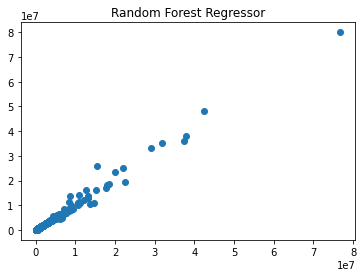

In [26]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_prediction)
rf_rmse = np.sqrt(mean_squared_error(rf_prediction, y_test))
plt.title("Random Forest Regressor")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")
plt.scatter(rf_prediction, y_test)
plt.show()

## Model Building: Decision Tree Regressor

Decision Tree RMSE: 1181263.8082841448
Decision Tree R2: 0.962413709941883


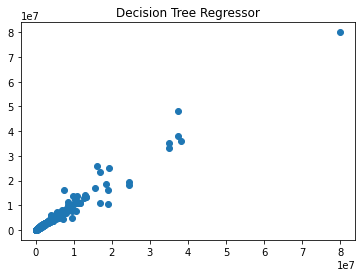

In [27]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_prediction = dt_model.predict(X_test)
dt_r2 = r2_score(y_test, dt_prediction)
dt_rmse = np.sqrt(mean_squared_error(dt_prediction, y_test))
plt.title("Decision Tree Regressor")
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R2: {dt_r2}")
plt.scatter(dt_prediction, y_test)
plt.show()

## Hyper-parameter Tuning for best model

In [28]:
# random forest for this case
hyperparams = {
    'min_samples_leaf' : [1, 5, 8],
    'n_estimators' : [50, 100, 150]
}

model = RandomForestRegressor()
gridcv = GridSearchCV(model, hyperparams, cv=3, verbose=3)
gridcv.fit(features, target)
print(gridcv.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END min_samples_leaf=1, n_estimators=50;, score=0.843 total time=   0.2s
[CV 2/3] END min_samples_leaf=1, n_estimators=50;, score=0.906 total time=   0.2s
[CV 3/3] END min_samples_leaf=1, n_estimators=50;, score=0.945 total time=   0.2s
[CV 1/3] END min_samples_leaf=1, n_estimators=100;, score=0.844 total time=   0.5s
[CV 2/3] END min_samples_leaf=1, n_estimators=100;, score=0.916 total time=   0.6s
[CV 3/3] END min_samples_leaf=1, n_estimators=100;, score=0.947 total time=   0.5s
[CV 1/3] END min_samples_leaf=1, n_estimators=150;, score=0.841 total time=   0.8s
[CV 2/3] END min_samples_leaf=1, n_estimators=150;, score=0.920 total time=   0.9s
[CV 3/3] END min_samples_leaf=1, n_estimators=150;, score=0.943 total time=   0.9s
[CV 1/3] END min_samples_leaf=5, n_estimators=50;, score=0.828 total time=   0.1s
[CV 2/3] END min_samples_leaf=5, n_estimators=50;, score=0.912 total time=   0.1s
[CV 3/3] END min_samples_leaf=5,

In [29]:
# Train and test on best hyper-parameters 
model = RandomForestRegressor(min_samples_leaf=1, n_estimators=100)
model.fit(X_train, y_train)

# Predict and report RMSE, R2
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'[INFO] RMSE = {rmse}; R2 score = {r2}')

[INFO] RMSE = 806265.8846271338; R2 score = 0.9824897546049939


## Cross Validation (Not working, don't run)

In [ ]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

stratas = pd.cut(target, bins=5)
splitter = StratifiedShuffleSplit(n_splits=10)

summary_rmse = {
    "lr" : [],
    "dt" : [],
    "rf" : [],
}

summary_r2 = {
    "lr" : [],
    "dt" : [],
    "rf" : [],
}

for train_index, val_index in splitter.split(features, stratas):
    X_train, X_val = features.loc[train_index], features.loc[val_index]
    Y_train, Y_val = target.loc[train_index], target.loc[val_index]
    
    # Fit all models
    lr.fit(X_train, Y_train)
    dt.fit(X_train, Y_train)
    rf.fit(X_train, Y_train)
    
    # Let all models make predictions on the validation dataset
    pred_lr = lr.predict(X_val)
    pred_dt = dt.predict(X_val)
    pred_rf = rf.predict(X_val)
    
    # Calculate the RMSE of each model on the validation set
    rmse_lr = np.sqrt(mean_squared_error(pred_lr, Y_val))
    rmse_dt = np.sqrt(mean_squared_error(pred_dt, Y_val))
    rmse_rf = np.sqrt(mean_squared_error(pred_rf, Y_val))   
    
    # Add these RMSE to the respective list
    summary_acc['lr'].append(acc_lr)
    summary_acc['dt'].append(acc_dt)
    summary_acc['rf'].append(acc_rf)
    
    # Calculate the r2 score of each model on the validation set
    r2_lr = r2_score(Y_val, pred_lr)
    r2_dt = r2_score(Y_val, pred_dt)
    r2_rf = r2_score(Y_val, pred_rf)
    
    # Add these r2 scores to the respective list
    summary_f1['lr'].append(f1_lr)
    summary_f1['dt'].append(f1_dt)
    summary_f1['rf'].append(f1_rf)
    

## Model Evaluation (RMSE, MAE, R2)

In [ ]:
# Print out the summary to decide the best model to pick
for model in summary_rmse.keys():
    rmse = np.array(summary_rmse[model]).mean()
    print(f'Mean RMSE of model {model} is {rmse}')

print("------------------------------")
    
for model in summary_r2.keys():
    r2 = np.array(summary_r2[model]).mean()
    print(f'Mean R2-score of model {model} is {r2}')